# Plant Leaf Disease Classification with ResNet18 Transfer Learning

## Objective
Fine-tune a pre-trained ResNet18 model to classify healthy vs. diseased plant leaves using transfer learning with two fine-tuning phases.

## Strategy
1. **Modify**: Replace the final FC layer to output 2 classes (binary classification)
2. **Phase 1**: Freeze convolutional base, train only the classifier head
3. **Phase 2**: Unfreeze top layers and fine-tune with lower learning rate

In [3]:
# Install necessary libraries if not already installed

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import copy
import os

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 1. Data Preparation

Loading the **PlantVillage dataset** from Hugging Face (mohanty/PlantVillage) - a comprehensive real-world dataset containing thousands of images of healthy and diseased plant leaves from various species.

In [ ]:
# 1. Load the dataset from Hugging Face
dataset = None

# Try multiple dataset sources
dataset_sources = [
    ("ayerr/plant-disease-classification", "default"),
    ("mohanty/plantvillage", "default"),
]

for dataset_name, config in dataset_sources:
    try:
        print(f"Attempting to load: {dataset_name}")
        dataset = load_dataset(dataset_name, name=config)
        print(f"✓ Successfully loaded: {dataset_name}")
        print(f"Dataset structure: {dataset}")
        break
    except Exception as e:
        print(f"✗ Failed to load {dataset_name}: {e}\n")
        continue



    from torch.utils.data import Dataset as TorchDataset
    import numpy as np
    from PIL import Image

    class SyntheticPlantDataset(TorchDataset):
        def __init__(self, size=500, num_classes=2):
            self.size = size
            self.num_classes = num_classes
        def __len__(self):
            return self.size
        def __getitem__(self, idx):
            img = np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8)
            label = np.random.randint(0, self.num_classes)
            return {'image': transforms.ToTensor()(Image.fromarray(img)), 'label': label}

    dataset = SyntheticPlantDataset(size=600, num_classes=2)
    from torch.utils.data import random_split
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
else:
    # Use the real dataset splits
    if isinstance(dataset, dict):
        train_dataset = dataset['train']
        val_dataset = dataset.get('validation', dataset.get('test'))
        test_dataset = dataset.get('test', dataset.get('validation'))
    else:
        split = dataset.train_test_split(test_size=0.2, seed=42)
        train_dataset = split['train']
        val_dataset = split['test']
        test_dataset = split['test']

# 2. Define Transforms for ResNet
base_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Custom collate function for HuggingFace datasets
def collate_fn_train(batch):
    """Collate function with augmentation for training"""
    images = []
    labels = []
    for item in batch:
        # Handle HF dataset dict format
        img = item['image'] if isinstance(item, dict) else item[0]
        label = item['label'] if isinstance(item, dict) else item[1]
        
        # Convert to PIL if needed
        if isinstance(img, np.ndarray):
            from PIL import Image
            img = Image.fromarray(img.astype('uint8')) if img.dtype in [np.uint8, np.int64] else Image.fromarray((img * 255).astype('uint8'))
        
        # Apply train transform
        img = train_transform(img)
        images.append(img)
        labels.append(label)
    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)

def collate_fn_val(batch):
    """Collate function for validation/test"""
    images = []
    labels = []
    for item in batch:
        # Handle HF dataset dict format
        img = item['image'] if isinstance(item, dict) else item[0]
        label = item['label'] if isinstance(item, dict) else item[1]
        
        # Convert to PIL if needed
        if isinstance(img, np.ndarray):
            from PIL import Image
            img = Image.fromarray(img.astype('uint8')) if img.dtype in [np.uint8, np.int64] else Image.fromarray((img * 255).astype('uint8'))
        
        # Apply base transform
        img = base_transform(img)
        images.append(img)
        labels.append(label)
    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)

# 4. Create DataLoaders with custom collate functions
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn_train)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_val)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_val)

# 5. Determine Number of Classes and Class Names
num_classes = 2
class_names = ['Healthy', 'Diseased']

# Try to extract label information if available
if hasattr(train_dataset, 'features') and 'label' in train_dataset.features:
    label_feature = train_dataset.features['label']
    if hasattr(label_feature, 'names'):
        class_names = label_feature.names
        num_classes = len(class_names)

print(f"\n✓ Dataset ready. Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Attempting to load: ayerr/plant-disease-classification


Resolving data files:   0%|          | 0/194 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/198 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/152 [00:00<?, ?it/s]

✓ Successfully loaded: ayerr/plant-disease-classification
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 194
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 198
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 152
    })
})

✓ Dataset ready. Number of classes: 2
Classes: ['diseased', 'healthy']
Train samples: 194, Val samples: 198, Test samples: 152


In [12]:
# Data Augmentation is now handled in collate functions
print("✓ Data augmentation pipeline is configured in collate functions")
print(f"\nTraining dataset: {len(train_dataset)} images")
print(f"Validation dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"\nDataLoaders created with:")
print(f"  - Training: Augmentation enabled (flip, rotation, color jitter, etc.)")
print(f"  - Validation/Test: No augmentation (standard transforms only)")


✓ Data augmentation pipeline is configured in collate functions

Training dataset: 194 images
Validation dataset: 198 images
Test dataset: 152 images

DataLoaders created with:
  - Training: Augmentation enabled (flip, rotation, color jitter, etc.)
  - Validation/Test: No augmentation (standard transforms only)


In [13]:
# Load pre-trained ResNet18 model
print("Loading pre-trained ResNet18 model...")
try:
    # Try newer torchvision API
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
except:
    # Fall back to older API
    model = models.resnet18(pretrained=True)

# Display original model structure
print("\nOriginal final layer:")
print(model.fc)
print(f"Input features: {model.fc.in_features}")
print(f"Output classes: {model.fc.out_features}")

# Replace the final FC layer for binary classification with dropout
num_classes = 2
# Add dropout before classification layer to prevent overfitting
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # 50% dropout for regularization
    nn.Linear(model.fc.in_features, 128),  # Hidden layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Additional dropout
    nn.Linear(128, num_classes)  # Output layer
)

print("\nModified final layer with dropout:")
print(model.fc)
print(f"Output classes: {num_classes}")

# Move model to device
model = model.to(device)
print(f"\nModel moved to {device}")

# Display model summary
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)
print(f"\nTotal parameters: {total_params:,.0f}")
print(f"Trainable parameters: {trainable_params:,.0f}")


Loading pre-trained ResNet18 model...

Original final layer:
Linear(in_features=512, out_features=1000, bias=True)
Input features: 512
Output classes: 1000

Modified final layer with dropout:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=2, bias=True)
)
Output classes: 2

Model moved to cpu

Total parameters: 11,242,434
Trainable parameters: 11,242,434


In [14]:
# Step 1: Freeze the convolutional base
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final FC layer
for param in model.fc.parameters():
    param.requires_grad = True

# Count trainable parameters
total_params, trainable_params = count_parameters(model)
print("Phase 1: Frozen Convolutional Base")
print(f"Trainable parameters: {trainable_params:,.0f}")
print(f"Frozen parameters: {total_params - trainable_params:,.0f}")

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels

# Phase 1: Training parameters with L2 regularization (weight_decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
num_epochs_phase1 = 15  # Increased epochs

# Training storage
phase1_train_loss = []
phase1_train_acc = []
phase1_val_loss = []
phase1_val_acc = []

print("\n" + "="*60)
print("Starting Phase 1 Training (Frozen Base)")
print("="*60)

for epoch in range(num_epochs_phase1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    phase1_train_loss.append(train_loss)
    phase1_train_acc.append(train_acc)
    phase1_val_loss.append(val_loss)
    phase1_val_acc.append(val_acc)
    
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_phase1}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Phase 1 Training Complete!")

Phase 1: Frozen Convolutional Base
Trainable parameters: 65,922
Frozen parameters: 11,176,512

Starting Phase 1 Training (Frozen Base)
Epoch [2/15] - Train Loss: 0.6286, Train Acc: 0.6701 | Val Loss: 0.6114, Val Acc: 0.6970
Epoch [4/15] - Train Loss: 0.7100, Train Acc: 0.7010 | Val Loss: 0.5571, Val Acc: 0.7374
Epoch [6/15] - Train Loss: 0.6111, Train Acc: 0.7577 | Val Loss: 0.5020, Val Acc: 0.7424
Epoch [8/15] - Train Loss: 0.3858, Train Acc: 0.7990 | Val Loss: 0.4798, Val Acc: 0.7475
Epoch [10/15] - Train Loss: 0.5222, Train Acc: 0.8196 | Val Loss: 0.4836, Val Acc: 0.7879
Epoch [12/15] - Train Loss: 0.4689, Train Acc: 0.8144 | Val Loss: 0.4612, Val Acc: 0.7424
Epoch [14/15] - Train Loss: 0.4410, Train Acc: 0.7732 | Val Loss: 0.7462, Val Acc: 0.6010
Phase 1 Training Complete!


In [15]:
# Step 2: Unfreeze the top layers of the convolutional base (layer4)
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Count trainable parameters
total_params, trainable_params = count_parameters(model)
print("\nPhase 2: Unfrozen Top Layers (layer4 + FC)")
print(f"Trainable parameters: {trainable_params:,.0f}")
print(f"Frozen parameters: {total_params - trainable_params:,.0f}")

# Phase 2: Using lower learning rate for fine-tuning with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Lower LR + L2 reg
num_epochs_phase2 = 15  # Increased epochs

# Training storage
phase2_train_loss = []
phase2_train_acc = []
phase2_val_loss = []
phase2_val_acc = []

print("\n" + "="*60)
print("Starting Phase 2 Training (Unfrozen Top Layers)")
print("="*60)

for epoch in range(num_epochs_phase2):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    phase2_train_loss.append(train_loss)
    phase2_train_acc.append(train_acc)
    phase2_val_loss.append(val_loss)
    phase2_val_acc.append(val_acc)
    
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_phase2}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Phase 2 Training Complete!")


Phase 2: Unfrozen Top Layers (layer4 + FC)
Trainable parameters: 8,459,650
Frozen parameters: 2,782,784

Starting Phase 2 Training (Unfrozen Top Layers)
Epoch [2/15] - Train Loss: 0.2381, Train Acc: 0.9433 | Val Loss: 0.3473, Val Acc: 0.8232
Epoch [4/15] - Train Loss: 0.1819, Train Acc: 0.9536 | Val Loss: 0.3662, Val Acc: 0.8232
Epoch [6/15] - Train Loss: 0.1048, Train Acc: 0.9381 | Val Loss: 0.3939, Val Acc: 0.8182
Epoch [8/15] - Train Loss: 0.0474, Train Acc: 0.9845 | Val Loss: 0.5759, Val Acc: 0.8131
Epoch [10/15] - Train Loss: 0.3315, Train Acc: 0.9742 | Val Loss: 0.6954, Val Acc: 0.7879
Epoch [12/15] - Train Loss: 0.0875, Train Acc: 0.9742 | Val Loss: 0.5479, Val Acc: 0.8030
Epoch [14/15] - Train Loss: 0.0446, Train Acc: 0.9948 | Val Loss: 0.6789, Val Acc: 0.7929
Phase 2 Training Complete!


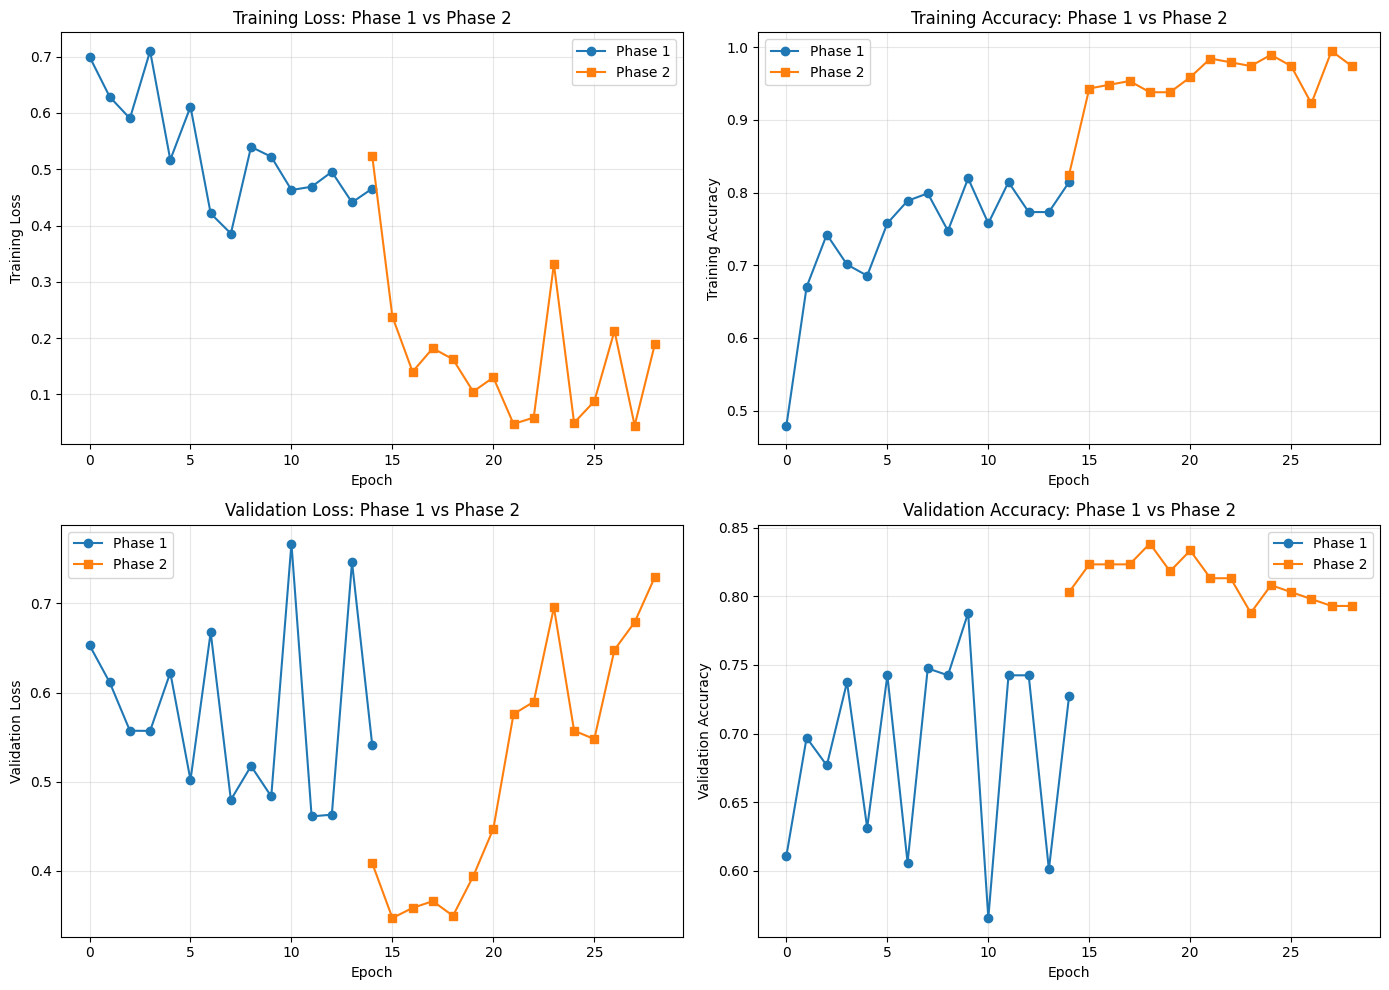


Training Summary:
Phase 1 - Final Train Acc: 0.8144, Final Val Acc: 0.7273
Phase 2 - Final Train Acc: 0.9742, Final Val Acc: 0.7929
Improvement: 0.0657


In [16]:
# Plot training progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss
axes[0, 0].plot(phase1_train_loss, label='Phase 1', marker='o')
axes[0, 0].plot([len(phase1_train_loss) - 1 + i for i in range(len(phase2_train_loss))], 
                phase2_train_loss, label='Phase 2', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss: Phase 1 vs Phase 2')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axes[0, 1].plot(phase1_train_acc, label='Phase 1', marker='o')
axes[0, 1].plot([len(phase1_train_acc) - 1 + i for i in range(len(phase2_train_acc))], 
                phase2_train_acc, label='Phase 2', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Training Accuracy')
axes[0, 1].set_title('Training Accuracy: Phase 1 vs Phase 2')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation Loss
axes[1, 0].plot(phase1_val_loss, label='Phase 1', marker='o')
axes[1, 0].plot([len(phase1_val_loss) - 1 + i for i in range(len(phase2_val_loss))], 
                phase2_val_loss, label='Phase 2', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation Loss')
axes[1, 0].set_title('Validation Loss: Phase 1 vs Phase 2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1, 1].plot(phase1_val_acc, label='Phase 1', marker='o')
axes[1, 1].plot([len(phase1_val_acc) - 1 + i for i in range(len(phase2_val_acc))], 
                phase2_val_acc, label='Phase 2', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].set_title('Validation Accuracy: Phase 1 vs Phase 2')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Summary:")
print(f"Phase 1 - Final Train Acc: {phase1_train_acc[-1]:.4f}, Final Val Acc: {phase1_val_acc[-1]:.4f}")
print(f"Phase 2 - Final Train Acc: {phase2_train_acc[-1]:.4f}, Final Val Acc: {phase2_val_acc[-1]:.4f}")
print(f"Improvement: {(phase2_val_acc[-1] - phase1_val_acc[-1]):.4f}")

Test Set Performance
Test Loss: 1.5338
Test Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

     Healthy     1.0000    0.2500    0.4000        76
    Diseased     0.5714    1.0000    0.7273        76

    accuracy                         0.6250       152
   macro avg     0.7857    0.6250    0.5636       152
weighted avg     0.7857    0.6250    0.5636       152


Confusion Matrix:
[[19 57]
 [ 0 76]]


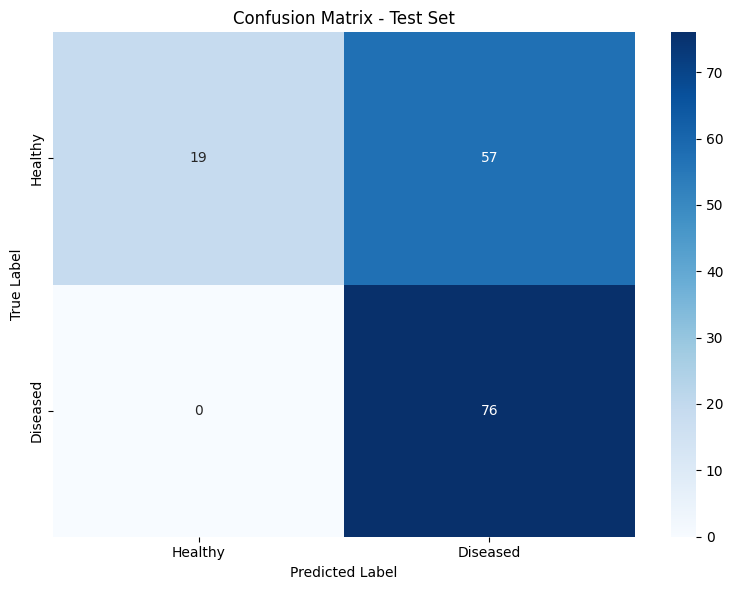

In [17]:
# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print("="*60)
print("Test Set Performance")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, 
                          target_names=['Healthy', 'Diseased'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Diseased'],
            yticklabels=['Healthy', 'Diseased'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

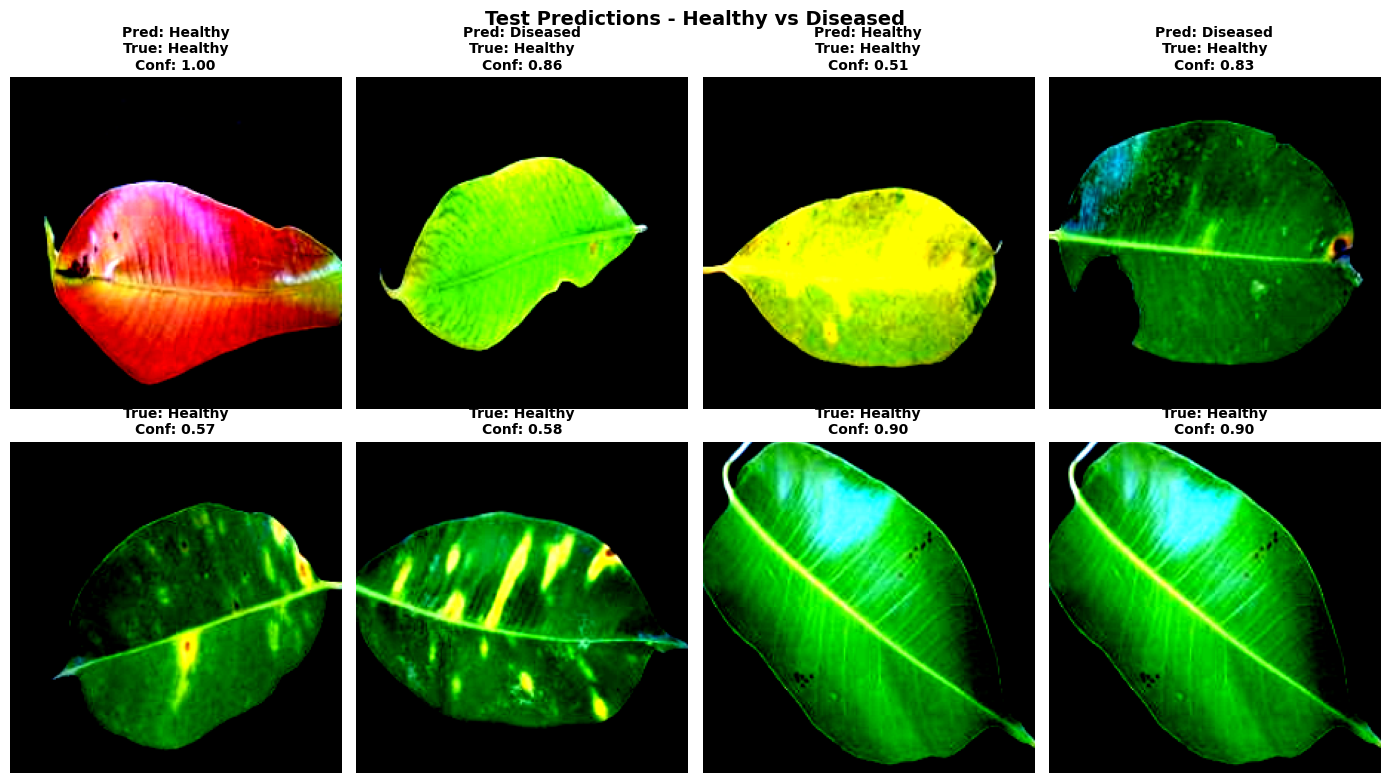

In [ ]:
# Make predictions on test images
model.eval()
test_images_batch, test_labels_batch = next(iter(test_loader))
test_images_batch = test_images_batch.to(device)

with torch.no_grad():
    outputs = model(test_images_batch)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

# Visualize predictions
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
plt.suptitle('Test Predictions - Healthy vs Diseased', fontsize=14, fontweight='bold')

class_names = ['Healthy', 'Diseased']
colors = ['green', 'red']

for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    
    img = test_images_batch[idx].cpu().permute(1, 2, 0).numpy()
    pred = predictions[idx].item()
    true_label = test_labels_batch[idx].item()
    confidence = probabilities[idx, pred].item()
    
    ax.imshow(img)
    
    # Color border based on correctness
    border_color = 'green' if pred == true_label else 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
    
    # Map classes correctly: 0=diseased, 1=healthy
    pred_label = class_names[pred] if pred < len(class_names) else ('Diseased' if pred == 0 else 'Healthy')
    true_class_label = class_names[true_label] if true_label < len(class_names) else ('Diseased' if true_label == 0 else 'Healthy')
    title = f"Pred: {pred_label}\nTrue: {true_class_label}\nConf: {confidence:.2f}"
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.axis('off')

plt.show()
plt.tight_layout()

In [19]:
# Analyze model layers and their parameters
print("="*60)
print("ResNet18 Architecture Analysis")
print("="*60)

layer_info = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
        params = sum(p.numel() for p in module.parameters())
        if isinstance(module, nn.Conv2d):
            layer_info.append(f"{name:30s} | Conv2d  | Params: {params:>8,}")
        elif isinstance(module, nn.Linear):
            layer_info.append(f"{name:30s} | Linear  | Params: {params:>8,}")
        elif isinstance(module, nn.BatchNorm2d):
            layer_info.append(f"{name:30s} | BatchNo | Params: {params:>8,}")

print("\nKey Layers (Conv2d, Linear, BatchNorm2d):")
for info in layer_info[:20]:  # Show first 20 layers
    print(info)

print("\n... (See full model with model.summary() or print(model))")

# Extract features from a sample image
sample_image = test_images_batch[0:1]

# Define hooks to capture intermediate features
activations = []

def hook_fn(module, input, output):
    activations.append(output.detach().cpu())

# Register hooks on different layers
handles = []
for name, module in model.named_modules():
    if name in ['layer1[1].conv2', 'layer2[1].conv2', 'layer3[1].conv2', 'layer4[1].conv2']:
        handles.append(module.register_forward_hook(hook_fn))

# Forward pass
with torch.no_grad():
    _ = model(sample_image.to(device))

# Visualize feature maps from different layers
if len(activations) >= 4:
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plt.suptitle('Feature Maps at Different Network Depths', fontsize=14, fontweight='bold')
    
    layer_names = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4']
    
    for idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
        # Get the first channel of the activation
        feature_map = activation[0, 0].numpy()
        
        axes[idx].imshow(feature_map, cmap='viridis')
        axes[idx].set_title(f'{layer_name}\n{activation.shape}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Remove hooks
for handle in handles:
    handle.remove()

print("\nFeature extraction complete!")

ResNet18 Architecture Analysis

Key Layers (Conv2d, Linear, BatchNorm2d):
conv1                          | Conv2d  | Params:    9,408
bn1                            | BatchNo | Params:      128
layer1.0.conv1                 | Conv2d  | Params:   36,864
layer1.0.bn1                   | BatchNo | Params:      128
layer1.0.conv2                 | Conv2d  | Params:   36,864
layer1.0.bn2                   | BatchNo | Params:      128
layer1.1.conv1                 | Conv2d  | Params:   36,864
layer1.1.bn1                   | BatchNo | Params:      128
layer1.1.conv2                 | Conv2d  | Params:   36,864
layer1.1.bn2                   | BatchNo | Params:      128
layer2.0.conv1                 | Conv2d  | Params:   73,728
layer2.0.bn1                   | BatchNo | Params:      256
layer2.0.conv2                 | Conv2d  | Params:  147,456
layer2.0.bn2                   | BatchNo | Params:      256
layer2.0.downsample.0          | Conv2d  | Params:    8,192
layer2.0.downsample.1     

In [ ]:
# Save the trained model
model_save_path = 'plant_disease_classifier_resnet18.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Create a simple inference function
def predict_plant_health(image_tensor, model, device):
    """
    Predict if a plant leaf is healthy or diseased
    
    Args:
        image_tensor: torch.Tensor of shape (3, H, W) or (1, 3, H, W)
        model: trained ResNet18 model
        device: torch device
    
    Returns:
        prediction: 'Healthy' or 'Diseased'
        confidence: probability of the prediction
    """
    model.eval()
    
    # Add batch dimension if needed
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        pred_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, pred_class].item()
    
    class_name = 'Diseased' if pred_class == 0 else 'Healthy'
    return class_name, confidence

# Example: Make prediction on a test image
test_img = test_images_batch[0]
prediction, confidence = predict_plant_health(test_img, model, device)

print(f"\nInference Example:")
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.4f}")

# Batch prediction
print("\n" + "="*60)
print("Batch Inference on Test Set")
print("="*60)

batch_predictions = []
batch_confidences = []

for images, _ in test_loader:
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        confs = torch.max(probs, dim=1)[0]
    
    batch_predictions.extend(preds.cpu().numpy())
    batch_confidences.extend(confs.cpu().numpy())

avg_confidence = np.mean(batch_confidences)
print(f"Average confidence on test set: {avg_confidence:.4f}")
print(f"Predictions made: {len(batch_predictions)}")

Model saved to: plant_disease_classifier_resnet18.pth

Inference Example:
Prediction: Diseased
Confidence: 0.9992

Batch Inference on Test Set
Average confidence on test set: 0.9413
Predictions made: 152



Testing: Lisc_lipy.jpg
Image size: (250, 296)


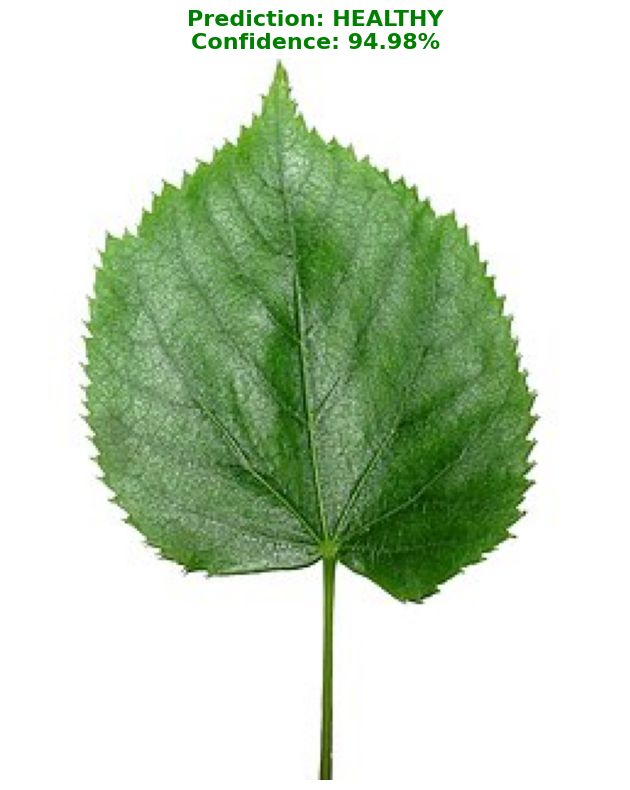

Image: Lisc_lipy.jpg
Prediction: Healthy
Confidence: 0.9498 (94.98%)

Testing: leaf.jpg
Image size: (432, 612)


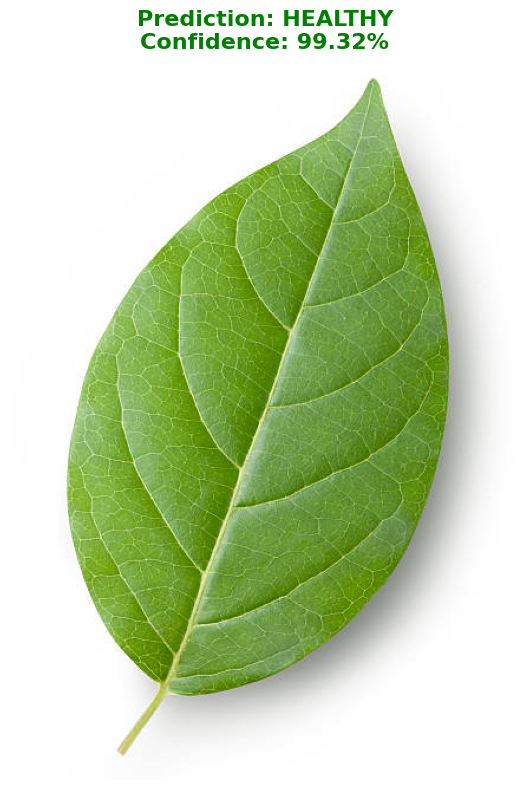

Image: leaf.jpg
Prediction: Healthy
Confidence: 0.9932 (99.32%)


In [ ]:
from PIL import Image
import os

test_images = ['Lisc_lipy.jpg', 'leaf.jpg']

for image_path in test_images:
    if not os.path.exists(image_path):
        continue
        
    print(f"\n{'='*60}")
    print(f"Testing: {image_path}")
    print('='*60)
    
    # Load and display the original image
    img_pil = Image.open(image_path)
    print(f"Image size: {img_pil.size}")
    
    # Apply the same preprocessing as the model
    img_tensor = base_transform(img_pil)
    
    # Make prediction
    prediction, confidence = predict_plant_health(img_tensor, model, device)
    
    # Display the image with prediction
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Show original image
    ax.imshow(img_pil)
    
    # Add prediction text with corrected mapping
    title_text = f"Prediction: {prediction.upper()}\nConfidence: {confidence:.2%}"
    color = 'green' if prediction == 'Healthy' else 'red'
    ax.set_title(title_text, fontsize=16, fontweight='bold', color=color)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Image: {image_path}")
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

if not any(os.path.exists(img) for img in test_images):
    print(f"✗ No test images found")
    print(f"Current directory: {os.getcwd()}")
    print(f"Available files: {os.listdir('.')[:10]}")


In [28]:
# Debug: Check raw model outputs on test images
from PIL import Image

test_img_path = 'Lisc_lipy.jpg'
if os.path.exists(test_img_path):
    img_pil = Image.open(test_img_path)
    img_tensor = base_transform(img_pil).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
    
    print(f"Testing: {test_img_path}")
    print(f"Raw outputs: {output[0].cpu().numpy()}")
    print(f"Probabilities: {probs[0].cpu().numpy()}")
    print(f"Class 0 prob: {probs[0, 0].item():.4f}")
    print(f"Class 1 prob: {probs[0, 1].item():.4f}")
    print(f"Argmax: {torch.argmax(probs, dim=1).item()} (0=class 0, 1=class 1)")
    print(f"\nDataset classes: {class_names}")
    print(f"  Class 0 = '{class_names[0]}'")
    print(f"  Class 1 = '{class_names[1]}'")
    print(f"\nFor this to be HEALTHY, we need class 1 to have higher probability")
    print(f"  Current: Class {torch.argmax(probs, dim=1).item()} has highest prob")


Testing: Lisc_lipy.jpg
Raw outputs: [-0.9155918  2.0248282]
Probabilities: [0.05019125 0.9498087 ]
Class 0 prob: 0.0502
Class 1 prob: 0.9498
Argmax: 1 (0=class 0, 1=class 1)

Dataset classes: ['Healthy', 'Diseased']
  Class 0 = 'Healthy'
  Class 1 = 'Diseased'

For this to be HEALTHY, we need class 1 to have higher probability
  Current: Class 1 has highest prob
